# COURSE: A deep understanding of deep learning
## SECTION: RNNs (and LSTM and GRU)
### LECTURE: Predicting alternating sequences
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [2]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create temporal sequence data

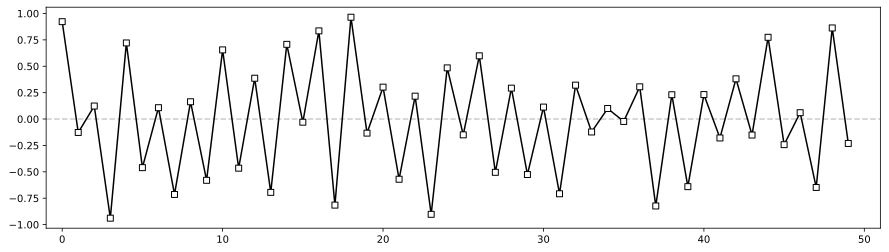

In [3]:
# import the data
N = 50

data = torch.zeros(N)

for i in range(N):
  data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

# Create a class for the DL model

In [4]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x):
    
    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden

In [5]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  5 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  9 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [6]:
# test the model with some data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor(0.6748, grad_fn=<MseLossBackward0>)

# Train the model and show performance

In [7]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    # also get sign accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*(truesign==predsign)
    segacc.append(accuracy)
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

In [8]:
truesign

np.float32(-1.0)

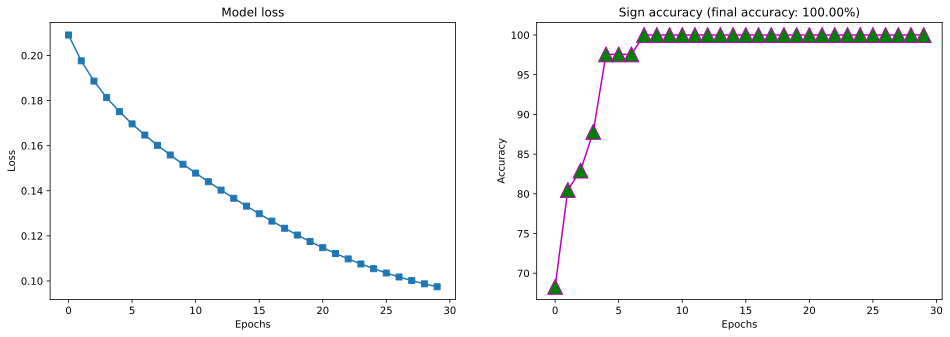

In [9]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

# Now test the network!


C:\Users\smscp\AppData\Local\Temp\ipykernel_25196\2517081452.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  h[timei+seqlength,:] = hh.detach()
C:\Users\smscp\AppData\Local\Temp\ipykernel_25196\2517081452.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1].plot(data-yHat,'k^')


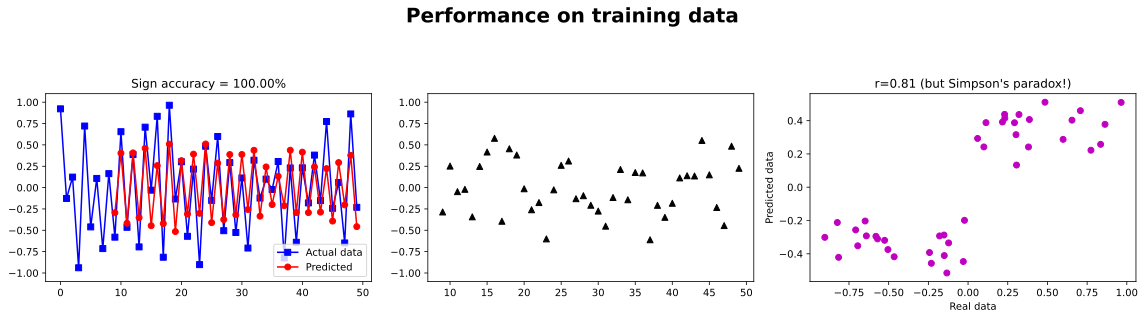

In [10]:
# initialize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)
yHat[:] = np.nan


# loop over time segments
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


## compute sign-accuracy
truesign = np.sign(data.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

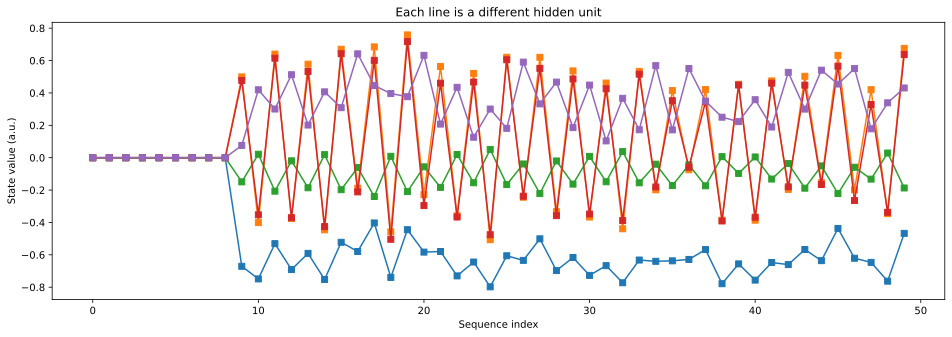

In [11]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

# Test with new data

In [12]:
# Create new data WITH FLIPPED SIGNS!
newdata = torch.zeros(N)
for i in range(N):
  newdata[i] = torch.rand(1) * (-1)**(i+1)

C:\Users\smscp\AppData\Local\Temp\ipykernel_25196\3180746289.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  h[timei+seqlength,:] = hh.detach()
C:\Users\smscp\AppData\Local\Temp\ipykernel_25196\3180746289.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[1].plot(newdata-yHat,'k^')


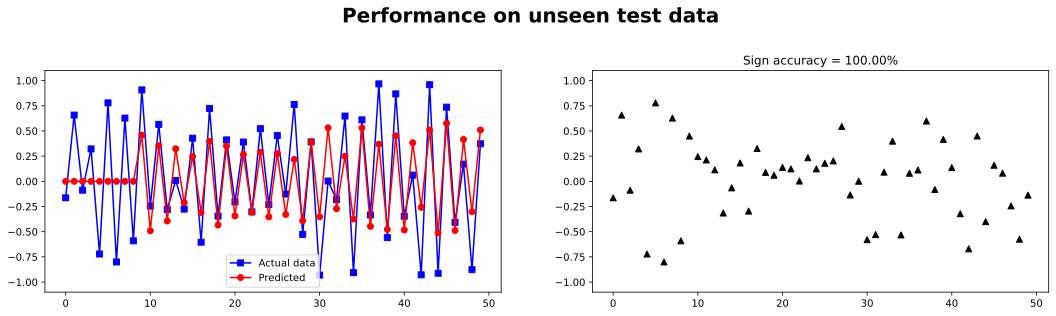

In [13]:
## now test the network!
# note: no learning here!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
for timei in range(N-seqlength):

  # grab a snippet of data
  X = newdata[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


# compute sign-accuracy
truesign = np.sign(newdata.numpy())
predsign = np.sign(yHat)
signaccuracy = 100*np.mean(truesign[seqlength:]==predsign[seqlength:])


fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signaccuracy)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

TypeError: only length-1 arrays can be converted to Python scalars

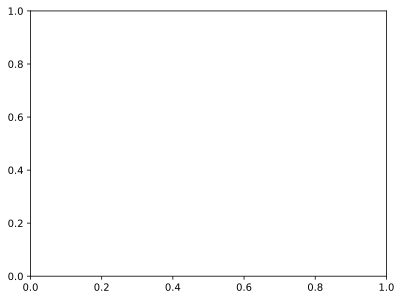

In [14]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach())
plt.ylabel('Weight value')
plt.show()

# Additional explorations

In [ ]:
# 1) Is the model overfitting? One way to check is by setting the signs to be random instead of alternating. You can do 
#    this by modifying the data-generation code to normal random numbers without forcing the sign. What is the predicted
#    accuracy level in this case?
# 
# 2) The hidden state is typically initialized to zeros. Is that really the best initialization? Weights are initialized
#    to random numbers. What happens if you initialize the hidden state to randn()? Run the model several times to get a
#    sense of the general trends. Now try initializing to all 100 (instead of zeros). Why are you getting these results?
# 
# 3) The data problem here (predicting alternating signs) is pretty easy. Would this same model architecture perform as
#    well for more complicated sequences? As a start, modify the data-generating code to have the sequence ++- (thus, 
#    two positive numbers and a negative number, then repeat that sign-pattern over and over again). Once you have this
#    code, you can test a variety of sign-sequencies, like ++--, --+, ++---, etc. Lots of fun to be had ;)
# 
# 4) I set the sequence length to be 9. Do you think that's a good value here? Of course, this is a metaparameter that
#    you can pick, and the exact numerical value is a bit arbitrary. But some values are more appropriate than other
#    values, depending on the nature of the data. Based on what you know about our sequence data, what do you think about
#    the value of 9? What sequence lengths would be appropriate for the suggested sequences in question #3? 
# 